# Data Preparation

In [5]:
!pip install -q kaggle
!pip install -q tensorflow
!pip install -q opencv-python
!pip install split-folders


import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [6]:
from google.colab import files
uploaded = files.upload()

import zipfile
import os

zip_path = 'archive.zip'
extract_path = '/content/archive'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

dataset = '/content/archive/archive/archive'


Saving archive.zip to archive.zip


In [7]:
all_files = os.listdir(dataset)
print(all_files[:10])

['AC_4770.txt', 'BI_5780.txt', 'AX_4260.jpeg', 'AX_9890.txt', 'AC_4350.jpeg', 'BH_1920.txt', 'AW_4320.txt', 'AB_7670.jpeg', 'AG_9710.txt', 'AX_800.txt']


Image count: 855
['AX_4260.jpeg', 'AC_4350.jpeg', 'AB_7670.jpeg', 'BE_4250.jpeg', 'AX_4830.jpeg']


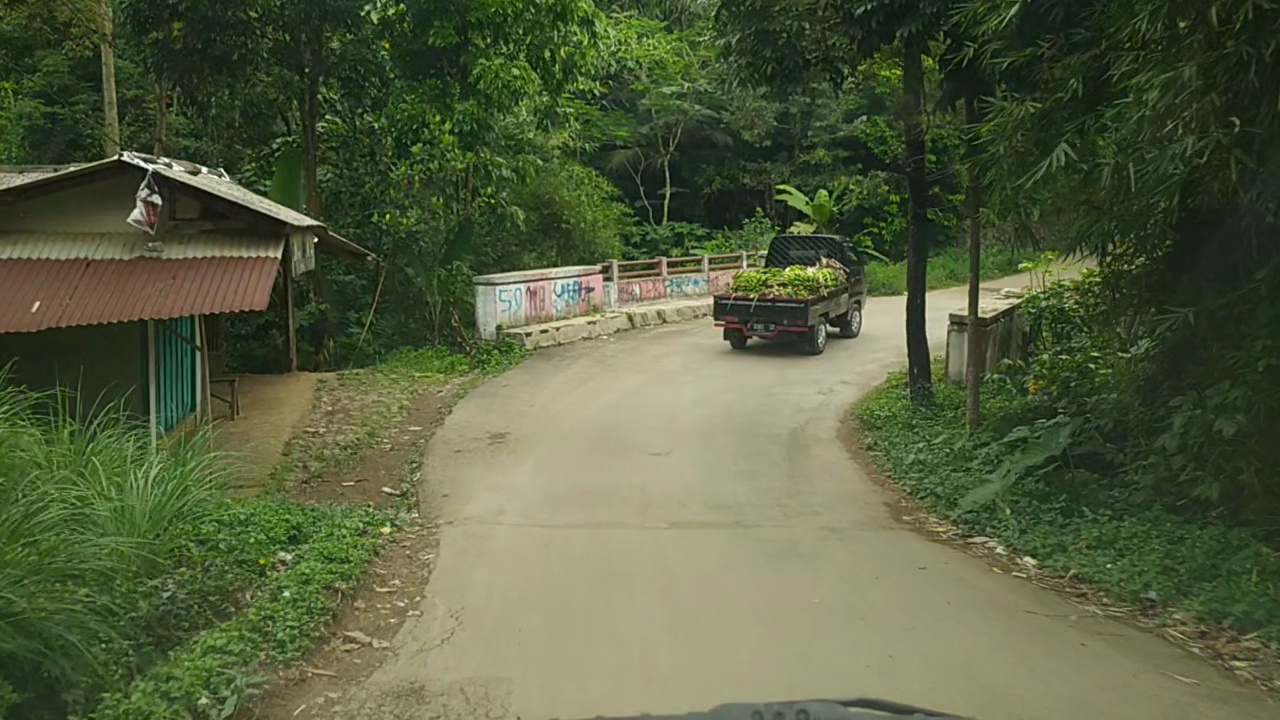

In [8]:
from PIL import Image

#ada seberapa banyak image dengan jenis jpeg yang ada di dataset
file_list = os.listdir(dataset)
images = [file for file in file_list if file.split(".")[-1].lower() == "jpeg"]
print("Image count:", len(images))
print(images[:5])

#memuat 1 image dari dataset
selectedImage = os.path.join(dataset, images[7])
Image.open(selectedImage)

# Model Preperation

In [9]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans

base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

def extract_features(image_path):
    img = Image.open(image_path).resize((224,224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = base_model.predict(x)
    return features.flatten()

dataset = '/content/archive/archive/archive'
images = [f for f in os.listdir(dataset) if f.lower().endswith(('jpeg', 'jpg', 'png'))]

features = []
for img_name in images:
    path = os.path.join(dataset, img_name)
    feat = extract_features(path)
    features.append(feat)

features = np.array(features)

#ada 4 cluster untuk tiap tipe dari road damage
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(features)

for img_name, cluster_id in zip(images, labels):
    print(f"{img_name} --> Cluster {cluster_id}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1

In [10]:
import shutil

cluster_output_dir = '/content/clustered_images'
os.makedirs(cluster_output_dir, exist_ok=True)

for cluster_id in range(num_clusters):
    cluster_folder = os.path.join(cluster_output_dir, f"cluster_{cluster_id}")
    os.makedirs(cluster_folder, exist_ok=True)

for img_name, cluster_id in zip(images, labels):
    src_path = os.path.join(dataset, img_name)
    dst_path = os.path.join(cluster_output_dir, f"cluster_{cluster_id}", img_name)
    shutil.copy(src_path, dst_path)


# Model Processing (CNN MODEL)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    '/content/clustered_images',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/content/clustered_images',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 685 images belonging to 4 classes.
Found 170 images belonging to 4 classes.


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [13]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.4693 - loss: 1.3629 - val_accuracy: 0.7235 - val_loss: 0.6937
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8951 - loss: 0.3028 - val_accuracy: 0.7765 - val_loss: 0.4999
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9549 - loss: 0.1521 - val_accuracy: 0.7824 - val_loss: 0.5357
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9712 - loss: 0.1071 - val_accuracy: 0.7588 - val_loss: 0.5693
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9792 - loss: 0.0855 - val_accuracy: 0.7471 - val_loss: 0.6267


In [15]:
model.save('road_damage_classifier.keras')

# Model Evaluation

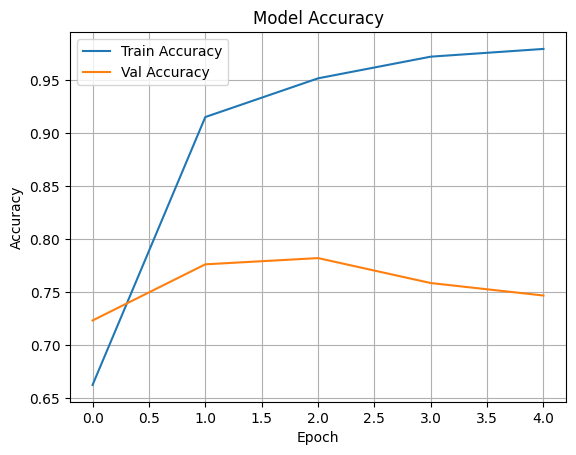

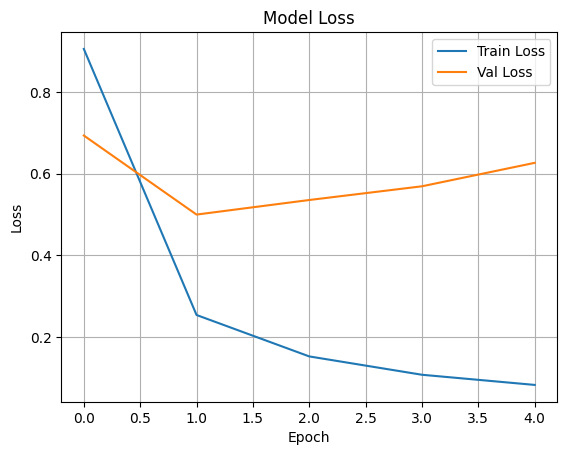

In [16]:
#visualisasi loss dan accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step


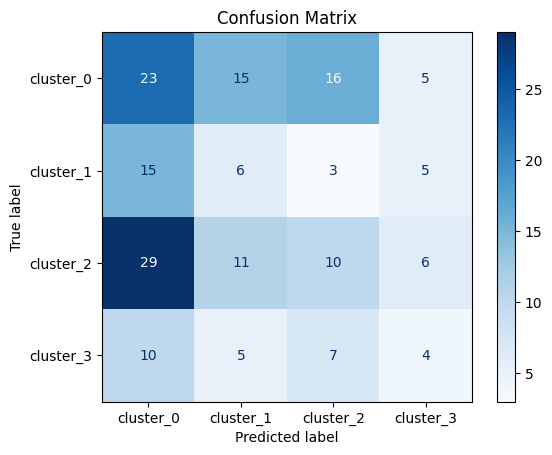

In [17]:
#memakai confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [18]:
#F-1, Precision, Recall, dan Support Score dari klasifikasi
from sklearn.metrics import classification_report

target_names = list(val_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))


              precision    recall  f1-score   support

   cluster_0       0.30      0.39      0.34        59
   cluster_1       0.16      0.21      0.18        29
   cluster_2       0.28      0.18      0.22        56
   cluster_3       0.20      0.15      0.17        26

    accuracy                           0.25       170
   macro avg       0.23      0.23      0.23       170
weighted avg       0.25      0.25      0.25       170

